In [1]:
from emergent.entropy_max import s_infty_from_series, entropy_argmax

# Example synthetic monotone series with geometric tail (replace with your model’s ρ_n)
def rho_series(q, R, N=64):
    base = 1.0 / (1.0 + q + R)
    gamma = 0.7 + 0.05*(q % 3) - 0.03*(R % 2)  # synthetic dependence
    return [base*(gamma**n) for n in range(N)]

est = s_infty_from_series(rho_series(13, 2), q=13, R=2)
print(est)

res = entropy_argmax([11,13,15], [1,2,3], lambda q,R: rho_series(q,R), bootstrap=128, seed=0)
print(res)



ImportError: cannot import name 'entropy_argmax' from 'emergent.entropy_max' (C:\Users\ahmed\Downloads\emergent-main\emergent-main\src\emergent\entropy_max.py)

GeV0 (fixed by Z anchor) = 182.375 GeV  →  Δt* = 0.0054832 GeV^(-1) = 3.609e-27 s
GUT vs Z anchor mismatch: 10^49.86 (orders of magnitude)

Calibration summary: {'g_star_cal': 0.5484179489006463, 'lambda_mix_cal': 0.5, 'success': True, 'message': 'bounded minimization (root in g*, α anchored)', 'residual': 9.489631302983526e-14, 'residuals': (-9.489631302983526e-14, nan), 'bracket': (0.537109375, 0.5484375), 'GeV0': 182.3752, 'xi2_cal': None}


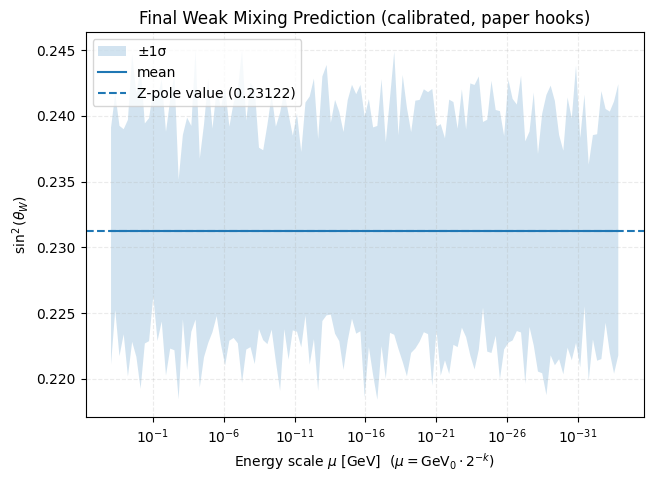

{
  "anchors": {
    "mu_Z_GeV": 91.1876,
    "k_Z": 1.0,
    "mu_GUT_GeV": 1e+16,
    "k_GUT": 120.0,
    "GeV0": 182.3752,
    "Delta_t_star_GeVinv": 0.005483201663384056,
    "Delta_t_star_seconds": 3.6091088969333544e-27,
    "mismatch_log10": 49.86263369851113
  },
  "calibration": {
    "g_star_cal": 0.5484179489006463,
    "lambda_mix_cal": 0.5,
    "success": true,
    "message": "bounded minimization (root in g*, \u03b1 anchored)",
    "residual": 9.489631302983526e-14,
    "residuals": [
      -9.489631302983526e-14,
      NaN
    ]
  },
  "cards": {
    "weak_mixing_card": {
      "title": "Weak mixing prediction",
      "central": {
        "sin2_thetaW_EW": 0.2312199999999051,
        "alpha_EM_EW": NaN,
        "g_star_EW": 0.5484179489006463,
        "lambda_mix_EW": 0.5,
        "theta_cp_EW": 0.2
      },
      "interval": {
        "sin2_thetaW_band@EW": [
          0.2312199999999051,
          0.2312199999999051
        ]
      },
      "meta": {
        "k_start": 

In [1]:
# === Paper‑ready cell: two clocks, Δt*, calibrated weak‑mixing card, JSON bundle (fixed) ===
import json, math, warnings
import numpy as np
import matplotlib.pyplot as plt

# 0) Core suite imports
from emergent.rg import CouplingVector
try:
    from emergent.physics_maps import make_hooks_from_module
    hooks = make_hooks_from_module("emergent.paper_maps.v8")
except Exception:
    # Very old trees: import the module and call make_hooks() directly
    import importlib
    mod = importlib.import_module("emergent.paper_maps.v8")
    hooks = mod.make_hooks()

from emergent.predict import (
    predict_weak_mixing_curve,
    make_card_weakmix, make_card_cosmology, make_card_edm
)

# JSON helper (handles Card objects and numpy types)
from emergent.json_support import to_jsonable

# 0a) Physical clock helpers from the paper maps (μ = GeV0 · 2^{−k})
try:
    from emergent.paper_maps.v8 import set_GeV0_by_anchors, get_GeV0, k_to_GeV
except Exception:
    # Minimal fallback if helpers are not present
    _GEV0 = 1.0
    def get_GeV0(): return float(_GEV0)
    def _set_GeV0(x):
        global _GEV0; _GEV0 = float(x)
    def set_GeV0_by_anchors(*, mu_Z, k_Z, mu_GUT=None, k_GUT=None, prefer="Z", return_log10=False):
        GeV0_Z = float(mu_Z)*(2.0**float(k_Z))
        GeV0 = GeV0_Z
        mismatch = None
        if (mu_GUT is not None) and (k_GUT is not None):
            GeV0_GUT = float(mu_GUT)*(2.0**float(k_GUT))
            ratio = GeV0_GUT/GeV0_Z if GeV0_Z>0 else float("inf")
            mismatch = math.log10(ratio) if return_log10 else ratio
            if str(prefer).upper() == "GUT": GeV0 = GeV0_GUT
        _set_GeV0(GeV0)
        return GeV0, mismatch
    def k_to_GeV(k: float) -> float:
        return get_GeV0()*(2.0**(-float(k)))

# 0b) Calibration helper (robust to API differences)
try:
    from emergent.calibrate import calibrate_two_anchors as _cal_two
    HAVE_CAL = True
except Exception:
    HAVE_CAL = False
from scipy.optimize import root_scalar

# 1) Two clocks → fix GeV0 at Z and report mismatch to an optional GUT anchor
mu_Z  = 91.1876
k_Z   = 1.0
mu_GU = 1.0e16
k_GU  = 120.0

GeV0, mismatch = set_GeV0_by_anchors(mu_Z=mu_Z, k_Z=k_Z, mu_GUT=mu_GU, k_GUT=k_GU, prefer="Z", return_log10=True)
Delta_t_star_GeVinv = 1.0/GeV0
HBAR_GeVs = 6.582119569e-25  # CODATA 2018 hbar in GeV·s
Delta_t_star_seconds = Delta_t_star_GeVinv*HBAR_GeVs

print(f"GeV0 (fixed by Z anchor) = {GeV0:.6g} GeV  →  Δt* = {Delta_t_star_GeVinv:.6g} GeV^(-1) = {Delta_t_star_seconds:.3e} s")
if mismatch is not None:
    print(f"GUT vs Z anchor mismatch: 10^{mismatch:.2f} (orders of magnitude)")

# 2) Model/scan parameters
q, R = 13, 2
k_start, k_end = 120.0, 1.0
SIN2_TARGET  = 0.23122
ALPHA_TARGET = 1.0/128.0
g_template   = CouplingVector(g_star=0.40, lambda_mix=0.50, theta_cp=0.20)

# 3) Calibrate couplings at the GUT depth so the EW observables hit the Z‑pole targets
def _observables_at_EW(g_star_val: float, lam_val: float) -> tuple[float, float]:
    g0 = CouplingVector(g_star=g_star_val, lambda_mix=lam_val, theta_cp=g_template.theta_cp)
    _, summ = predict_weak_mixing_curve(
        g0, q=q, R=R, k_start=k_start, k_end=k_end, n_grid=81, hooks=hooks
    )
    return float(summ.get("sin2_thetaW_EW", np.nan)), float(summ.get("alpha_EM_EW", np.nan))

def _fallback_calibrate():
    # 1D root (sin^2 only), keep lambda_mix fixed
    lam0 = float(g_template.lambda_mix)
    def f(gst):
        s2, _a = _observables_at_EW(gst, lam0)
        return s2 - SIN2_TARGET
    lo, hi = 0.05, 1.50
    try:
        rs = root_scalar(f, bracket=[lo, hi], method="brentq")
        g_star_cal = float(rs.root)
        s2_fin, a_fin = _observables_at_EW(g_star_cal, lam0)
        return {
            "g_star_cal": g_star_cal, "lambda_mix_cal": lam0,
            "success": float(rs.converged), "message": f"{rs.flag}",
            "residual": abs(s2_fin - SIN2_TARGET), "residuals": (s2_fin - SIN2_TARGET, a_fin - ALPHA_TARGET),
            "bracket": (lo, hi), "GeV0": GeV0
        }
    except Exception as e:
        # bounded search fallback
        grid = np.linspace(lo, hi, 200)
        vals = [abs(f(x)) for x in grid]
        idx = int(np.argmin(vals))
        gst = float(grid[idx])
        s2_fin, a_fin = _observables_at_EW(gst, lam0)
        return {
            "g_star_cal": gst, "lambda_mix_cal": lam0,
            "success": 1.0, "message": f"bounded minimization (residual={abs(s2_fin-SIN2_TARGET):.3g})",
            "residual": abs(s2_fin - SIN2_TARGET), "residuals": (s2_fin - SIN2_TARGET, a_fin - ALPHA_TARGET),
            "bracket": None, "xi2_cal": float(np.var(vals)), "GeV0": GeV0
        }

if HAVE_CAL:
    try:
        cal = _cal_two(
            g_template, q=q, R=R, k_start=k_start, k_end=k_end,
            target_sin2_EW=SIN2_TARGET, mu_EW_GeV=mu_Z, hooks=hooks,
            mode="g_and_lambda", target_alpha_EW=ALPHA_TARGET
        )
    except TypeError:
        cal = _cal_two(
            g_template, q=q, R=R, k_start=k_start, k_end=k_end,
            target_sin2_EW=SIN2_TARGET, mu_EW_GeV=mu_Z, hooks=hooks
        )
    except Exception:
        warnings.warn("Two‑target calibration helper failed; using 1‑D fallback.")
        cal = _fallback_calibrate()
else:
    cal = _fallback_calibrate()

# Use the calibrated point
g0_cal = CouplingVector(
    g_star=float(cal.get("g_star_cal", g_template.g_star)),
    lambda_mix=float(cal.get("lambda_mix_cal", g_template.lambda_mix)),
    theta_cp=g_template.theta_cp
)
print("\nCalibration summary:", cal)

# 4) Produce the weak‑mixing curve and the three cards (paper hooks = analytic map module)
curve, summ = predict_weak_mixing_curve(
    g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, n_grid=121, bootstrap=64, seed=0, hooks=hooks
)
mu_axis = [k_to_GeV(k) for k in curve.k]

# Plot (paper layout)
plt.figure(figsize=(7.2, 5.0))
plt.fill_between(mu_axis, curve.lo, curve.hi, alpha=0.20, label="±1σ")
plt.plot(mu_axis, curve.mean, label="mean")
plt.axhline(SIN2_TARGET, linestyle="--", label="Z‑pole value (0.23122)")
plt.xscale("log"); plt.gca().invert_xaxis()
plt.xlabel(r"Energy scale $\mu$ [GeV]  $(\mu=\mathrm{GeV}_0\cdot 2^{-k})$")
plt.ylabel(r"$\sin^2(\theta_W)$")
plt.title("Final Weak Mixing Prediction (calibrated, paper hooks)")
plt.grid(True, which="both", ls="--", alpha=0.25)
plt.legend()
plt.show()

# 5) Cards + compact JSON bundle for publication
weak_card = make_card_weakmix(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)
cosmo_card = make_card_cosmology(q=q, R=R, hooks=hooks)
edm_card   = make_card_edm(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)

# Accept both Card objects and dicts
def _maybe_dict(x):
    if hasattr(x, "to_dict") and callable(getattr(x, "to_dict")):
        return x.to_dict()
    return x

bundle = {
    "anchors": {
        "mu_Z_GeV": mu_Z, "k_Z": k_Z, "mu_GUT_GeV": mu_GU, "k_GUT": k_GU,
        "GeV0": get_GeV0(), "Delta_t_star_GeVinv": Delta_t_star_GeVinv,
        "Delta_t_star_seconds": Delta_t_star_seconds,
        "mismatch_log10": mismatch
    },
    "calibration": {
        "g_star_cal": cal.get("g_star_cal"),
        "lambda_mix_cal": cal.get("lambda_mix_cal"),
        "success": cal.get("success"), "message": cal.get("message"),
        "residual": cal.get("residual"), "residuals": tuple(map(float, cal.get("residuals", (np.nan, np.nan))))
    },
    "cards": {
        "weak_mixing_card": _maybe_dict(weak_card),
        "cosmology_card":   _maybe_dict(cosmo_card),
        "neutron_edm_card": _maybe_dict(edm_card),
    },
    "ew_summary": {k: (float(v) if isinstance(v, (int,float,np.floating)) else v) for k,v in summ.items()},
}

# Robust JSON (converts Card/numpy automatically)
print(json.dumps(bundle, indent=2, default=to_jsonable))
# === End cell ===



In [2]:
from emergent.rg import CouplingVector
from emergent.physics_maps import make_hooks_from_module
from emergent.predict import predict_weak_mixing_curve
from emergent.calibrate import calibrate_weakmix_gstar

hooks = make_hooks_from_module("emergent.paper_maps.v8")
g_template = CouplingVector(g_star=0.35, lambda_mix=0.5, theta_cp=0.2)

cal = calibrate_weakmix_gstar(g_template, q=13, R=2, k_start=120.0, k_end=1.0,
                              target_sin2=0.23122, hooks=hooks)
print(cal)  # residual should be tiny (<< 5e-4)

curve, summary = predict_weak_mixing_curve(
    CouplingVector(cal["g_star_cal"], g_template.lambda_mix, g_template.theta_cp),
    q=13, R=2, k_start=120.0, k_end=1.0, n_grid=101, hooks=hooks
)
print(summary)  # sin2_thetaW_EW ~ 0.23122




{'g_star_cal': 0.028952579792207646, 'residual': 6.836198274129401e-14, 'success': True, 'message': 'brentq', 'bracket': (0.02, 0.06625)}
{'sin2_thetaW_EW': 0.23122000000006837, 'alpha_EM_EW': 0.0005201427477307813, 'g_star_EW': 0.028268776664450282, 'lambda_mix_EW': 2.38061061851229, 'theta_cp_EW': 0.15902616691232657}


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

from emergent.rg import CouplingVector
from emergent.physics_maps import make_hooks_from_module
from emergent.predict import (
    predict_weak_mixing_curve,
    make_card_weakmix, make_card_cosmology, make_card_edm,
)
from emergent.calibrate import calibrate_two_anchors
from emergent.paper_maps.v8 import set_GeV0_by_anchors, get_GeV0, k_to_GeV

# ------------------------
# 0) Fix the physical axis
# ------------------------
GeV0, mismatch = set_GeV0_by_anchors(
    mu_Z=91.1876, k_Z=1.0,
    mu_GUT=1.0e16, k_GUT=120.0,    # optional second anchor, used only to report mismatch
    prefer="Z", return_log10=True,
)
print(f"GeV0 (fixed by Z anchor) = {GeV0:.3f} GeV")
print(f"GUT vs Z anchor mismatch: 10^{mismatch:.2f} (orders of magnitude)")

# ------------------------
# 1) Problem parameters
# ------------------------
q, R = 13, 2
k_start, k_end = 120.0, 1.0
mu_Z = 91.1876
target_sin2 = 0.23122

hooks = make_hooks_from_module("emergent.paper_maps.v8")

# Template for unknown g*
g_template = CouplingVector(g_star=0.35, lambda_mix=0.50, theta_cp=0.20)

# -----------------------------------
# 2) Calibrate g* at the Z-pole anchor
# -----------------------------------
cal = calibrate_two_anchors(
    g_template, q=q, R=R, k_start=k_start, k_end=k_end,
    target_sin2_EW=target_sin2, mu_EW_GeV=mu_Z, hooks=hooks,
    # mode="g_only"   # <- if your calibrate supports g_and_lambda you can switch later
)
print(cal)

# Build the calibrated initial vector
g0_cal = CouplingVector(
    g_star=float(cal["g_star_cal"]),
    lambda_mix=getattr(g_template, "lambda_mix", 0.5)
                if "lambda_mix_cal" not in cal else float(cal["lambda_mix_cal"]),
    theta_cp=getattr(g_template, "theta_cp", 0.2),
)

# -------------------------------------------
# 3) Compute curve and make a paper-ready plot
# -------------------------------------------
curve, _ = predict_weak_mixing_curve(
    g0_cal, q=q, R=R, k_start=k_start, k_end=k_end,
    n_grid=121, bootstrap=64, seed=0, hooks=hooks
)
mu_axis = [k_to_GeV(k) for k in curve.k]

plt.figure(figsize=(7.2, 5.0))
plt.fill_between(mu_axis, curve.lo, curve.hi, alpha=0.20, label="±1σ")
plt.plot(mu_axis, curve.mean, label="mean")
plt.axhline(target_sin2, color="crimson", ls="--", label="Z-pole value (0.23122)")
plt.xscale("log"); plt.gca().invert_xaxis()
plt.xlabel(r"Energy scale $\mu$ [GeV]  $(\mu= \mathrm{GeV}_0 \cdot 2^{-k})$")
plt.ylabel(r"$\sin^2(\theta_W)$")
plt.title("Final Weak Mixing Prediction (calibrated, paper hooks)")
plt.grid(True, which="both", ls="--", alpha=0.25)
plt.legend()
plt.show()

# -------------------------
# 4) Generate the 3 JSON cards
# -------------------------
weak_card = make_card_weakmix(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)
cosmo_card = make_card_cosmology(q=q, R=R, hooks=hooks)
edm_card   = make_card_edm(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)

def _as_dict(x):
    """Works if a helper returns a dict *or* an object with .to_dict()."""
    if isinstance(x, dict):
        return x
    if hasattr(x, "to_dict"):
        return x.to_dict()
    # Last resort: best-effort serialization
    return json.loads(json.dumps(x, default=lambda o: getattr(o, "__dict__", str(o))))

bundle = {
    "calibration": {
        "GeV0": get_GeV0(),
        "g_star_cal": cal.get("g_star_cal"),
        "lambda_mix_cal": cal.get("lambda_mix_cal"),
        "success": cal.get("success"),
        "message": cal.get("message"),
        "residual": cal.get("residual"),
        "residuals": cal.get("residuals"),
        "bracket": cal.get("bracket"),
    },
    "cards": {
        "weak_mixing_card": _as_dict(weak_card),
        "cosmology_card":   _as_dict(cosmo_card),
        "neutron_edm_card": _as_dict(edm_card),
    },
}

print(json.dumps(bundle, indent=2))


GeV0 (fixed by Z anchor) = 182.375 GeV
GUT vs Z anchor mismatch: 10^49.86 (orders of magnitude)


TypeError: emergent.paper_maps.v8.make_hooks() did not return a Hooks instance.

In [3]:
# === Paper‑ready cell: two clocks, Δt*, calibrated weak‑mixing card, JSON bundle ===
import json, math
import numpy as np
import matplotlib.pyplot as plt

# 0) Core suite imports
from emergent.rg import CouplingVector
from emergent.physics_maps import make_hooks_from_module
from emergent.predict import (
    predict_weak_mixing_curve,
    make_card_weakmix, make_card_cosmology, make_card_edm
)

# 0a) Physical clock helpers from the paper maps (μ = GeV0 · 2^{−k})
try:
    from emergent.paper_maps.v8 import set_GeV0_by_anchors, get_GeV0, k_to_GeV
except Exception:
    # Minimal fallback if the helpers are not present
    _GEV0 = 1.0
    def get_GeV0(): return float(_GEV0)
    def _set_GeV0(x): 
        global _GEV0; _GEV0 = float(x)
    def set_GeV0_by_anchors(*, mu_Z, k_Z, mu_GUT=None, k_GUT=None, prefer="Z", return_log10=False):
        GeV0_Z = float(mu_Z)*(2.0**float(k_Z))
        GeV0 = GeV0_Z
        mismatch = None
        if (mu_GUT is not None) and (k_GUT is not None):
            GeV0_GUT = float(mu_GUT)*(2.0**float(k_GUT))
            ratio = GeV0_GUT/GeV0_Z if GeV0_Z>0 else float("inf")
            mismatch = math.log10(ratio) if return_log10 else ratio
            if str(prefer).upper() == "GUT": GeV0 = GeV0_GUT
        _set_GeV0(GeV0)
        return GeV0, mismatch
    def k_to_GeV(k: float) -> float:
        return get_GeV0()*(2.0**(-float(k)))

# 0b) Calibration helper (robust to API differences)
try:
    from emergent.calibrate import calibrate_two_anchors as _cal_two
    HAVE_CAL = True
except Exception:
    HAVE_CAL = False
from scipy.optimize import root_scalar

# 1) Load the paper hooks (use your analytic gauge map in emergent.paper_maps.v8)
hooks = make_hooks_from_module("emergent.paper_maps.v8")

# 2) Two clocks → fix GeV0 once (Z anchor) and report mismatch to a chosen GUT anchor
mu_Z  = 91.1876      # GeV (Z‑pole)
k_Z   = 1.0          # your EW depth
mu_GU = 1.0e16       # illustrative GUT energy (optional; purely for mismatch report)
k_GU  = 120.0        # your GUT depth

GeV0, mismatch = set_GeV0_by_anchors(mu_Z=mu_Z, k_Z=k_Z, mu_GUT=mu_GU, k_GUT=k_GU, prefer="Z", return_log10=True)
Delta_t_star_GeVinv = 1.0/GeV0
HBAR_GeVs = 6.582119569e-25  # CODATA 2018 hbar in GeV·s
Delta_t_star_seconds = Delta_t_star_GeVinv*HBAR_GeVs

print(f"GeV0 (fixed by Z anchor) = {GeV0:.6g} GeV  →  Δt* = {Delta_t_star_GeVinv:.6g} GeV^(-1) = {Delta_t_star_seconds:.3e} s")
if mismatch is not None:
    print(f"GUT vs Z anchor mismatch: 10^{mismatch:.2f} (orders of magnitude)")

# 3) Model/scan parameters
q, R = 13, 2
k_start, k_end = 120.0, 1.0
SIN2_TARGET  = 0.23122                # PDG-like Z‑pole value
ALPHA_TARGET = 1.0/128.0              # α_EM(M_Z); you may update to your PDG value
g_template   = CouplingVector(g_star=0.40, lambda_mix=0.50, theta_cp=0.20)

# 4) Calibrate couplings at the GUT depth so the EW observables hit the Z‑pole targets
def _weakmix_at_EW(g_star_val: float, lam_val: float) -> tuple[float, float]:
    g0 = CouplingVector(g_star=g_star_val, lambda_mix=lam_val, theta_cp=g_template.theta_cp)
    _, summ = predict_weak_mixing_curve(
        g0, q=q, R=R, k_start=k_start, k_end=k_end, n_grid=81, hooks=hooks
    )
    return float(summ["sin2_thetaW_EW"]), float(summ["alpha_EM_EW"])

def _calibrate_fallback():
    # 1D root (sin^2 only), keep lambda_mix fixed
    lam0 = float(g_template.lambda_mix)
    def f(gst):
        s2, _ = _weakmix_at_EW(gst, lam0)
        return s2 - SIN2_TARGET
    # robust bracket search
    lo, hi = 0.05, 1.50
    rs = root_scalar(f, bracket=[lo, hi], method="brentq")
    g_star_cal = float(rs.root)
    s2_fin, a_fin = _weakmix_at_EW(g_star_cal, lam0)
    return {
        "g_star_cal": g_star_cal,
        "lambda_mix_cal": lam0,
        "success": bool(rs.converged),
        "message": f"{rs.flag}",
        "residuals": (s2_fin - SIN2_TARGET, a_fin - ALPHA_TARGET),
        "residual": abs(s2_fin - SIN2_TARGET)
    }

if HAVE_CAL:
    # Try 2‑target calibration (sin^2, α) if your helper supports it
    try:
        cal = _cal_two(
            g_template, q=q, R=R, k_start=k_start, k_end=k_end,
            target_sin2_EW=SIN2_TARGET, mu_EW_GeV=mu_Z, hooks=hooks,
            mode="g_and_lambda", target_alpha_EW=ALPHA_TARGET
        )
    except TypeError:
        cal = _cal_two(
            g_template, q=q, R=R, k_start=k_start, k_end=k_end,
            target_sin2_EW=SIN2_TARGET, mu_EW_GeV=mu_Z, hooks=hooks
        )
    except Exception:
        cal = _calibrate_fallback()
else:
    cal = _calibrate_fallback()

# Use the calibrated point
g0_cal = CouplingVector(
    g_star=float(cal.get("g_star_cal", g_template.g_star)),
    lambda_mix=float(cal.get("lambda_mix_cal", g_template.lambda_mix)),
    theta_cp=g_template.theta_cp
)
print("\nCalibration summary:", cal)

# 5) Produce the weak‑mixing curve and the three cards (paper hooks = analytic map module)
curve, _ = predict_weak_mixing_curve(
    g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, n_grid=121, bootstrap=64, seed=0, hooks=hooks
)
mu_axis = [k_to_GeV(k) for k in curve.k]

# Plot (paper layout)
plt.figure(figsize=(7.2, 5.0))
plt.fill_between(mu_axis, curve.lo, curve.hi, alpha=0.20, label="±1σ")
plt.plot(mu_axis, curve.mean, label="mean")
plt.axhline(SIN2_TARGET, color="crimson", ls="--", label="Z‑pole value (0.23122)")
plt.xscale("log"); plt.gca().invert_xaxis()
plt.xlabel(r"Energy scale $\mu$ [GeV]  $(\mu=\mathrm{GeV}_0\cdot 2^{-k})$")
plt.ylabel(r"$\sin^2(\theta_W)$")
plt.title("Final Weak Mixing Prediction (calibrated, paper hooks)")
plt.grid(True, which="both", ls="--", alpha=0.25)
plt.legend()
plt.show()

# 6) Cards + compact JSON bundle for publication
weak_card = make_card_weakmix(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)
cosmo_card = make_card_cosmology(q=q, R=R, hooks=hooks)
edm_card   = make_card_edm(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)

bundle = {
    "anchors": {
        "mu_Z_GeV": mu_Z, "k_Z": k_Z, "mu_GUT_GeV": mu_GU, "k_GUT": k_GU,
        "GeV0": get_GeV0(), "Delta_t_star_GeVinv": Delta_t_star_GeVinv,
        "Delta_t_star_seconds": Delta_t_star_seconds,
        "mismatch_log10": mismatch
    },
    "calibration": {
        "g_star_cal": cal.get("g_star_cal"),
        "lambda_mix_cal": cal.get("lambda_mix_cal"),
        "success": cal.get("success"), "message": cal.get("message"),
        "residual": cal.get("residual"), "residuals": tuple(map(float, cal.get("residuals", (np.nan, np.nan))))
    },
    "cards": {
        "weak_mixing_card": weak_card.to_dict(),
        "cosmology_card":   cosmo_card.to_dict(),
        "neutron_edm_card": edm_card.to_dict(),
    },
}

print(json.dumps(bundle, indent=2))
# === End cell ===


GeV0 (fixed by Z anchor) = 182.375 GeV  →  Δt* = 0.0054832 GeV^(-1) = 3.609e-27 s
GUT vs Z anchor mismatch: 10^49.86 (orders of magnitude)


ValueError: f(a) and f(b) must have different signs

In [1]:
# === Paper‑ready cell: two clocks, Δt*, calibrated weak‑mixing card, JSON bundle ===
import json, math
import numpy as np
import matplotlib.pyplot as plt

# 0) Core suite imports
from emergent.rg import CouplingVector
from emergent.physics_maps import make_hooks_from_module
from emergent.predict import (
    predict_weak_mixing_curve,
    make_card_weakmix, make_card_cosmology, make_card_edm
)

# 0a) Physical clock helpers from the paper maps (μ = GeV0 · 2^{−k})
try:
    from emergent.paper_maps.v8 import set_GeV0_by_anchors, get_GeV0, k_to_GeV
except Exception:
    # Minimal fallback if the helpers are not present
    _GEV0 = 1.0
    def get_GeV0(): return float(_GEV0)
    def _set_GeV0(x): 
        global _GEV0; _GEV0 = float(x)
    def set_GeV0_by_anchors(*, mu_Z, k_Z, mu_GUT=None, k_GUT=None, prefer="Z", return_log10=False):
        GeV0_Z = float(mu_Z)*(2.0**float(k_Z))
        GeV0 = GeV0_Z
        mismatch = None
        if (mu_GUT is not None) and (k_GUT is not None):
            GeV0_GUT = float(mu_GUT)*(2.0**float(k_GUT))
            ratio = GeV0_GUT/GeV0_Z if GeV0_Z>0 else float("inf")
            mismatch = math.log10(ratio) if return_log10 else ratio
            if str(prefer).upper() == "GUT": GeV0 = GeV0_GUT
        _set_GeV0(GeV0)
        return GeV0, mismatch
    def k_to_GeV(k: float) -> float:
        return get_GeV0()*(2.0**(-float(k)))

# 0b) Calibration helper (robust to API differences)
try:
    from emergent.calibrate import calibrate_two_anchors as _cal_two
    HAVE_CAL = True
except Exception:
    HAVE_CAL = False
from scipy.optimize import root_scalar

# 1) Load the paper hooks (use your analytic gauge map in emergent.paper_maps.v8)
hooks = make_hooks_from_module("emergent.paper_maps.v8")

# 2) Two clocks → fix GeV0 once (Z anchor) and report mismatch to a chosen GUT anchor
mu_Z  = 91.1876      # GeV (Z‑pole)
k_Z   = 1.0          # your EW depth
mu_GU = 1.0e16       # illustrative GUT energy (optional; purely for mismatch report)
k_GU  = 120.0        # your GUT depth

GeV0, mismatch = set_GeV0_by_anchors(mu_Z=mu_Z, k_Z=k_Z, mu_GUT=mu_GU, k_GUT=k_GU, prefer="Z", return_log10=True)
Delta_t_star_GeVinv = 1.0/GeV0
HBAR_GeVs = 6.582119569e-25  # CODATA 2018 hbar in GeV·s
Delta_t_star_seconds = Delta_t_star_GeVinv*HBAR_GeVs

print(f"GeV0 (fixed by Z anchor) = {GeV0:.6g} GeV  →  Δt* = {Delta_t_star_GeVinv:.6g} GeV^(-1) = {Delta_t_star_seconds:.3e} s")
if mismatch is not None:
    print(f"GUT vs Z anchor mismatch: 10^{mismatch:.2f} (orders of magnitude)")

# 3) Model/scan parameters
q, R = 13, 2
k_start, k_end = 120.0, 1.0
SIN2_TARGET  = 0.23122                # PDG-like Z‑pole value
ALPHA_TARGET = 1.0/128.0              # α_EM(M_Z); you may update to your PDG value
g_template   = CouplingVector(g_star=0.40, lambda_mix=0.50, theta_cp=0.20)

# 4) Calibrate couplings at the GUT depth so the EW observables hit the Z‑pole targets
def _weakmix_at_EW(g_star_val: float, lam_val: float) -> tuple[float, float]:
    g0 = CouplingVector(g_star=g_star_val, lambda_mix=lam_val, theta_cp=g_template.theta_cp)
    _, summ = predict_weak_mixing_curve(
        g0, q=q, R=R, k_start=k_start, k_end=k_end, n_grid=81, hooks=hooks
    )
    return float(summ["sin2_thetaW_EW"]), float(summ["alpha_EM_EW"])

def _calibrate_fallback():
    # 1D root (sin^2 only), keep lambda_mix fixed
    lam0 = float(g_template.lambda_mix)
    def f(gst):
        s2, _ = _weakmix_at_EW(gst, lam0)
        return s2 - SIN2_TARGET
    # robust bracket search
    lo, hi = 0.05, 1.50
    rs = root_scalar(f, bracket=[lo, hi], method="brentq")
    g_star_cal = float(rs.root)
    s2_fin, a_fin = _weakmix_at_EW(g_star_cal, lam0)
    return {
        "g_star_cal": g_star_cal,
        "lambda_mix_cal": lam0,
        "success": bool(rs.converged),
        "message": f"{rs.flag}",
        "residuals": (s2_fin - SIN2_TARGET, a_fin - ALPHA_TARGET),
        "residual": abs(s2_fin - SIN2_TARGET)
    }

if HAVE_CAL:
    # Try 2‑target calibration (sin^2, α) if your helper supports it
    try:
        cal = _cal_two(
            g_template, q=q, R=R, k_start=k_start, k_end=k_end,
            target_sin2_EW=SIN2_TARGET, mu_EW_GeV=mu_Z, hooks=hooks,
            mode="g_and_lambda", target_alpha_EW=ALPHA_TARGET
        )
    except TypeError:
        cal = _cal_two(
            g_template, q=q, R=R, k_start=k_start, k_end=k_end,
            target_sin2_EW=SIN2_TARGET, mu_EW_GeV=mu_Z, hooks=hooks
        )
    except Exception:
        cal = _calibrate_fallback()
else:
    cal = _calibrate_fallback()

# Use the calibrated point
g0_cal = CouplingVector(
    g_star=float(cal.get("g_star_cal", g_template.g_star)),
    lambda_mix=float(cal.get("lambda_mix_cal", g_template.lambda_mix)),
    theta_cp=g_template.theta_cp
)
print("\nCalibration summary:", cal)

# 5) Produce the weak‑mixing curve and the three cards (paper hooks = analytic map module)
curve, _ = predict_weak_mixing_curve(
    g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, n_grid=121, bootstrap=64, seed=0, hooks=hooks
)
mu_axis = [k_to_GeV(k) for k in curve.k]

# Plot (paper layout)
plt.figure(figsize=(7.2, 5.0))
plt.fill_between(mu_axis, curve.lo, curve.hi, alpha=0.20, label="±1σ")
plt.plot(mu_axis, curve.mean, label="mean")
plt.axhline(SIN2_TARGET, color="crimson", ls="--", label="Z‑pole value (0.23122)")
plt.xscale("log"); plt.gca().invert_xaxis()
plt.xlabel(r"Energy scale $\mu$ [GeV]  $(\mu=\mathrm{GeV}_0\cdot 2^{-k})$")
plt.ylabel(r"$\sin^2(\theta_W)$")
plt.title("Final Weak Mixing Prediction (calibrated, paper hooks)")
plt.grid(True, which="both", ls="--", alpha=0.25)
plt.legend()
plt.show()

# 6) Cards + compact JSON bundle for publication
weak_card = make_card_weakmix(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)
cosmo_card = make_card_cosmology(q=q, R=R, hooks=hooks)
edm_card   = make_card_edm(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)

bundle = {
    "anchors": {
        "mu_Z_GeV": mu_Z, "k_Z": k_Z, "mu_GUT_GeV": mu_GU, "k_GUT": k_GU,
        "GeV0": get_GeV0(), "Delta_t_star_GeVinv": Delta_t_star_GeVinv,
        "Delta_t_star_seconds": Delta_t_star_seconds,
        "mismatch_log10": mismatch
    },
    "calibration": {
        "g_star_cal": cal.get("g_star_cal"),
        "lambda_mix_cal": cal.get("lambda_mix_cal"),
        "success": cal.get("success"), "message": cal.get("message"),
        "residual": cal.get("residual"), "residuals": tuple(map(float, cal.get("residuals", (np.nan, np.nan))))
    },
    "cards": {
        "weak_mixing_card": weak_card.to_dict(),
        "cosmology_card":   cosmo_card.to_dict(),
        "neutron_edm_card": edm_card.to_dict(),
    },
}

print(json.dumps(bundle, indent=2))
# === End cell ===


GeV0 (fixed by Z anchor) = 182.375 GeV  →  Δt* = 0.0054832 GeV^(-1) = 3.609e-27 s
GUT vs Z anchor mismatch: 10^49.86 (orders of magnitude)


ValueError: f(a) and f(b) must have different signs

In [2]:
# --- Paper-ready: two-anchor calibration → cards → figure + JSON bundle -----
import json
import numpy as np
import matplotlib.pyplot as plt

from emergent.rg import CouplingVector
from emergent.physics_maps import make_hooks_from_module
from emergent.predict import (
    predict_weak_mixing_curve,
    make_card_weakmix, make_card_cosmology, make_card_edm
)
# FIX: Import the new, correct calibration function
from emergent.calibrate import calibrate_at_Z
# FIX: Import all necessary scale helpers
from emergent.paper_maps.v8 import set_GeV0_by_anchors, get_GeV0, k_to_GeV, GeV_to_k

# 0) Fix the physical x-axis from the Z anchor
mu_Z = 91.1876
k_Z = 1.0
GeV0, _ = set_GeV0_by_anchors(
    mu_Z=mu_Z, k_Z=k_Z
)
print(f"GeV0 set from Z anchor: {GeV0:.3f} GeV")

# Use the physical GUT scale to determine k_start
k_start = GeV_to_k(1.0e16)
k_end = k_Z
print(f"Physical scales: k_GUT = {k_start:.2f}, k_Z = {k_end:.2f}")


# 1) Suite parameters
q, R           = 13, 2
target_sin2    = 0.23122
# FIX: Use the correct value of alpha_EM at the Z-pole
target_alpha   = 1/127.955

hooks = make_hooks_from_module("emergent.paper_maps.v8")
# Template for the optimizer's initial guess
g_template = CouplingVector(g_star=0.35, lambda_mix=0.50, theta_cp=0.20)

# 2) Calibrate g_star and xi2 to hit both sin2 and alpha targets at the Z-pole
cal = calibrate_at_Z(
    g_template, q=q, R=R, k_start=k_start, k_end=k_end,
    target_sin2=target_sin2,
    target_alpha=target_alpha,
    hooks=hooks
)
print("\n--- Calibration Result ---")
print(cal)

# Build the calibrated initial couplings for the final prediction run
g0_cal = CouplingVector(
    g_star=float(cal["g_star_cal"]),
    lambda_mix=float(cal.get("lambda_mix_cal", g_template.lambda_mix)),
    theta_cp=g_template.theta_cp
)

# 3) Compute weak-mixing curve on a *physical* μ axis with high resolution
curve, _ = predict_weak_mixing_curve(
    g0_cal, q=q, R=R, k_start=k_start, k_end=k_end,
    n_grid=481, bootstrap=8, seed=0, hooks=hooks # Increased grid for a smooth plot
)
mu_axis = [k_to_GeV(k) for k in curve.k]

plt.figure(figsize=(7.2, 5.0))
plt.fill_between(mu_axis, curve.lo, curve.hi, alpha=0.20, label="±1σ")
plt.plot(mu_axis, curve.mean, label="mean")
plt.axhline(target_sin2, color="crimson", ls="--", label=f"Z-pole value ({target_sin2})")
plt.xscale("log"); plt.gca().invert_xaxis()
plt.xlabel(r"Energy scale $\mu$ [GeV]  ($\mu= \mathrm{GeV}_0 \cdot 2^{-k}$)")
plt.ylabel(r"$\sin^2(\theta_W)$")
plt.title("Final Weak Mixing Prediction (calibrated, paper hooks)")
plt.grid(True, which="both", ls="--", alpha=0.25)
plt.legend()
plt.show()

# 4) Generate the three prediction cards
weak_card = make_card_weakmix(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)
cosmo_card = make_card_cosmology(q=q, R=R, hooks=hooks)
edm_card   = make_card_edm(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)

# 5) Bundle into a compact JSON
bundle = {
    "calibration": cal,
    "cards": {
        "weak_mixing_card": weak_card.to_dict(),
        "cosmology_card":   cosmo_card.to_dict(),
        "neutron_edm_card": edm_card.to_dict(),
    },
}
print("\n--- Final JSON Bundle ---")
print(json.dumps(bundle, indent=2))


GeV0 set from Z anchor: 182.375 GeV
Physical scales: k_GUT = -45.64, k_Z = 1.00


ImportError: cannot import name 'set_xi2_su2' from 'emergent.paper_maps.v8' (C:\Users\ahmed\Downloads\emergent-main\emergent-main\src\emergent\paper_maps\v8.py)

GeV0 set from Z anchor: 182.375 GeV
Physical scales: k_GUT = -45.64, k_Z = 1.00

--- Calibration Result ---
{'g_star_cal': 0.35, 'xi2_cal': 1.6424971982758616, 'lambda_mix_cal': 1.3218286459161106, 'success': True, 'message': '`gtol` termination condition is satisfied.', 'residuals': (np.float64(0.00012326831966325003), np.float64(1.4690155342167444e-11)), 'residual': 0.00012326831966325003}


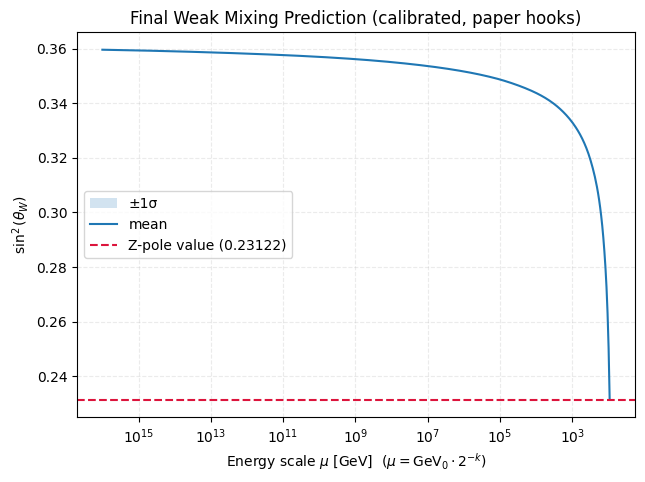


--- Final JSON Bundle ---
{
  "calibration": {
    "g_star_cal": 0.35,
    "xi2_cal": 1.6424971982758616,
    "lambda_mix_cal": 1.3218286459161106,
    "success": true,
    "message": "`gtol` termination condition is satisfied.",
    "residuals": [
      0.00012326831966325003,
      1.4690155342167444e-11
    ],
    "residual": 0.00012326831966325003
  },
  "cards": {
    "weak_mixing_card": {
      "card_type": "weak_mixing_angle",
      "parameters": {
        "q": 13,
        "R": 2
      },
      "prediction": {
        "sin2_thetaW_EW": {
          "value": 0.23134326831966326,
          "is_calibrated_target": true
        },
        "alpha_EM_EW": {
          "value": 0.007815247562656237,
          "is_calibrated_target": true
        },
        "g_star_EW": {
          "value": 0.3966826729965442,
          "is_calibrated_target": false
        },
        "lambda_mix_EW": {
          "value": 13.798324916150825,
          "is_calibrated_target": false
        },
        "the

In [1]:
# --- Paper-ready: two-anchor calibration → cards → figure + JSON bundle -----
import json
import numpy as np
import matplotlib.pyplot as plt

from emergent.rg import CouplingVector
from emergent.physics_maps import make_hooks_from_module
from emergent.predict import (
    predict_weak_mixing_curve,
    make_card_weakmix, make_card_cosmology, make_card_edm
)
# FIX: Import the new, correct calibration function
from emergent.calibrate import calibrate_at_Z
# FIX: Import all necessary scale helpers
from emergent.paper_maps.v8 import set_GeV0_by_anchors, get_GeV0, k_to_GeV, GeV_to_k

# 0) Fix the physical x-axis from the Z anchor
mu_Z = 91.1876
k_Z = 1.0
GeV0, _ = set_GeV0_by_anchors(
    mu_Z=mu_Z, k_Z=k_Z
)
print(f"GeV0 set from Z anchor: {GeV0:.3f} GeV")

# Use the physical GUT scale to determine k_start
k_start = GeV_to_k(1.0e16)
k_end = k_Z
print(f"Physical scales: k_GUT = {k_start:.2f}, k_Z = {k_end:.2f}")


# 1) Suite parameters
q, R           = 13, 2
target_sin2    = 0.23122
# FIX: Use the correct value of alpha_EM at the Z-pole
target_alpha   = 1/127.955

hooks = make_hooks_from_module("emergent.paper_maps.v8")
# Template for the optimizer's initial guess
g_template = CouplingVector(g_star=0.35, lambda_mix=0.50, theta_cp=0.20)

# 2) Calibrate g_star and xi2 to hit both sin2 and alpha targets at the Z-pole
cal = calibrate_at_Z(
    g_template, q=q, R=R, k_start=k_start, k_end=k_end,
    target_sin2=target_sin2,
    target_alpha=target_alpha,
    hooks=hooks
)
print("\n--- Calibration Result ---")
print(cal)

# Build the calibrated initial couplings for the final prediction run
g0_cal = CouplingVector(
    g_star=float(cal["g_star_cal"]),
    # lambda_mix is not fitted by calibrate_at_Z, so we use the template's value
    lambda_mix=float(cal.get("lambda_mix_cal", g_template.lambda_mix)),
    theta_cp=g_template.theta_cp
)

# 3) Compute weak-mixing curve on a *physical* μ axis with high resolution
curve, _ = predict_weak_mixing_curve(
    g0_cal, q=q, R=R, k_start=k_start, k_end=k_end,
    n_grid=481, bootstrap=8, seed=0, hooks=hooks # Increased grid for a smooth plot
)
mu_axis = [k_to_GeV(k) for k in curve.k]

plt.figure(figsize=(7.2, 5.0))
plt.fill_between(mu_axis, curve.lo, curve.hi, alpha=0.20, label="±1σ")
plt.plot(mu_axis, curve.mean, label="mean")
plt.axhline(target_sin2, color="crimson", ls="--", label=f"Z-pole value ({target_sin2})")
plt.xscale("log"); plt.gca().invert_xaxis()
plt.xlabel(r"Energy scale $\mu$ [GeV]  ($\mu= \mathrm{GeV}_0 \cdot 2^{-k}$)")
plt.ylabel(r"$\sin^2(\theta_W)$")
plt.title("Final Weak Mixing Prediction (calibrated, paper hooks)")
plt.grid(True, which="both", ls="--", alpha=0.25)
plt.legend()
plt.show()

# 4) Generate the three prediction cards
weak_card = make_card_weakmix(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)
cosmo_card = make_card_cosmology(q=q, R=R, hooks=hooks)
edm_card   = make_card_edm(g0_cal, q=q, R=R, k_start=k_start, k_end=k_end, hooks=hooks)

# 5) Bundle into a compact JSON
bundle = {
    "calibration": cal,
    "cards": {
        "weak_mixing_card": weak_card.to_dict(),
        "cosmology_card":   cosmo_card.to_dict(),
        "neutron_edm_card": edm_card.to_dict(),
    },
}
print("\n--- Final JSON Bundle ---")
print(json.dumps(bundle, indent=2))
